In [1]:
import os

import torch as th
from torch.utils.data import Dataset, Sampler, DataLoader
from transformers import BertTokenizer, BertModel

from sentence_transformers import SentenceTransformer

import numpy as np
import scipy.linalg as linalg

from tqdm.notebook import tqdm
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import umap
from sklearn.manifold import TSNE

import faiss

from examples.speech_to_text.data_utils import load_df_from_tsv

In [2]:
root = '/mnt/raid0/siqi/datasets/covost2'
langs = ["fr", "de", "es", "fa", "it", "ru", "pt", "zh-CN", "tr", "ar", "et", "mn", "nl", "sv-SE", "lv", "sl", "ta", "ja", "id"]
os.makedirs('resources', exist_ok=True)
device='cuda:7'

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertModel.from_pretrained("bert-base-cased").to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
model = SentenceTransformer('sentence-transformers/LaBSE').to(device)

In [22]:
for lang in langs:
    df = load_df_from_tsv(os.path.join(root, lang, 'dev_st_{}_en.tsv'.format(lang)))
    tgt_texts = df['tgt_text'].tolist()
    with th.inference_mode():
        features = []
        for i in tqdm(range(0, len(tgt_texts), 500), desc=lang):
            # inputs = tokenizer(text, return_tensors="pt").to('cuda')
            # outputs = model(**inputs)
            # features.append(outputs.last_hidden_state.cpu())
            outputs = model.encode(tgt_texts[i:i+500])
            features.append(outputs)
        features = np.concatenate(features, axis=0)
        np.save('resources/{}.npy'.format(lang), features)

fr:   0%|          | 0/30 [00:00<?, ?it/s]

de:   0%|          | 0/28 [00:00<?, ?it/s]

es:   0%|          | 0/27 [00:00<?, ?it/s]

fa:   0%|          | 0/7 [00:00<?, ?it/s]

it:   0%|          | 0/18 [00:00<?, ?it/s]

ru:   0%|          | 0/13 [00:00<?, ?it/s]

pt:   0%|          | 0/7 [00:00<?, ?it/s]

zh-CN:   0%|          | 0/10 [00:00<?, ?it/s]

tr:   0%|          | 0/4 [00:00<?, ?it/s]

ar:   0%|          | 0/4 [00:00<?, ?it/s]

et:   0%|          | 0/4 [00:00<?, ?it/s]

mn:   0%|          | 0/4 [00:00<?, ?it/s]

nl:   0%|          | 0/4 [00:00<?, ?it/s]

sv-SE:   0%|          | 0/3 [00:00<?, ?it/s]

lv:   0%|          | 0/3 [00:00<?, ?it/s]

sl:   0%|          | 0/2 [00:00<?, ?it/s]

ta:   0%|          | 0/1 [00:00<?, ?it/s]

ja:   0%|          | 0/2 [00:00<?, ?it/s]

id:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
means = []
covs = []
for i in tqdm(range(len(langs))):
    features = np.load('resources/{}.npy'.format(langs[i]))
    mean = features.mean(axis=0)
    cov = np.cov(features, rowvar=False)
    means.append(mean)
    covs.append(cov)

  0%|          | 0/19 [00:00<?, ?it/s]

In [14]:
matrix = np.zeros((len(langs), len(langs)))
for i in range(len(langs)):
    for j in tqdm(range(len(langs)), desc=langs[i]):
        if j > i:
            A = ((means[i] - means[j]) ** 2).sum()
            B = np.trace(covs[i] + covs[j] - 2 * linalg.sqrtm(np.matmul(covs[i], covs[j])))
            matrix[i, j] = (A + B) ** 0.5
        elif j == i:
            matrix[i, i] = 0.
        else:
            matrix[i, j] = matrix[j, i]

fr:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/ipykernel_22757/2123211394.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix[i, j] = (A + B) ** 0.5


de:   0%|          | 0/19 [00:00<?, ?it/s]

es:   0%|          | 0/19 [00:00<?, ?it/s]

fa:   0%|          | 0/19 [00:00<?, ?it/s]

it:   0%|          | 0/19 [00:00<?, ?it/s]

ru:   0%|          | 0/19 [00:00<?, ?it/s]

pt:   0%|          | 0/19 [00:00<?, ?it/s]

zh-CN:   0%|          | 0/19 [00:00<?, ?it/s]

tr:   0%|          | 0/19 [00:00<?, ?it/s]

ar:   0%|          | 0/19 [00:00<?, ?it/s]

et:   0%|          | 0/19 [00:00<?, ?it/s]

mn:   0%|          | 0/19 [00:00<?, ?it/s]

nl:   0%|          | 0/19 [00:00<?, ?it/s]

sv-SE:   0%|          | 0/19 [00:00<?, ?it/s]

lv:   0%|          | 0/19 [00:00<?, ?it/s]

sl:   0%|          | 0/19 [00:00<?, ?it/s]

ta:   0%|          | 0/19 [00:00<?, ?it/s]

ja:   0%|          | 0/19 [00:00<?, ?it/s]

id:   0%|          | 0/19 [00:00<?, ?it/s]

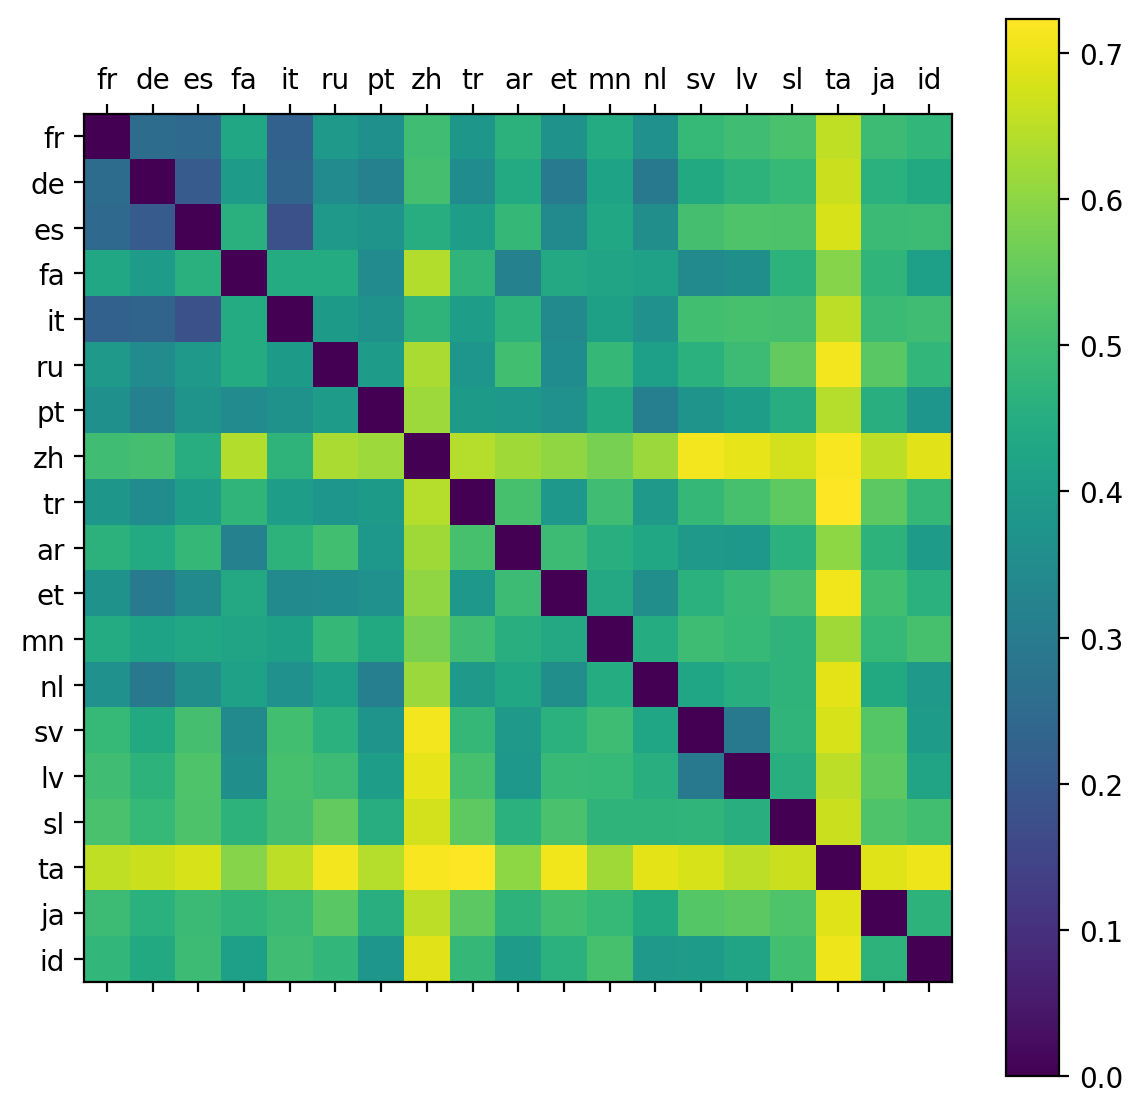

In [19]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(matrix) #, norm=mp.colors.Normalize(0, 7))
fig.colorbar(cax)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('frechet_dist.png')

In [24]:
all_features = []
n_labels = []
for i in tqdm(range(len(langs))):
    features = np.load('resources/{}.npy'.format(langs[i]))
    n_labels.append(features.shape[0])
    all_features.append(features)
all_features = np.concatenate(all_features, axis=0)

  0%|          | 0/19 [00:00<?, ?it/s]

In [66]:
projector = umap.UMAP(n_neighbors=10, n_components=2, metric='cosine', init='spectral', min_dist=0.01, local_connectivity=5, negative_sample_rate=10, verbose=True)
dots = projector.fit_transform(all_features)

UMAP(angular_rp_forest=True, local_connectivity=5, metric='cosine', min_dist=0.01, n_neighbors=10, negative_sample_rate=10, verbose=True)
Sun Feb 20 18:26:37 2022 Construct fuzzy simplicial set
Sun Feb 20 18:26:37 2022 Finding Nearest Neighbors
Sun Feb 20 18:26:37 2022 Building RP forest with 19 trees
Sun Feb 20 18:26:40 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	 9  /  16
	 10  /  16
	 11  /  16
	 12  /  16
	Stopping threshold met -- exiting after 12 iterations
Sun Feb 20 18:26:47 2022 Finished Nearest Neighbor Search
Sun Feb 20 18:26:47 2022 Construct embedding


KeyboardInterrupt: 

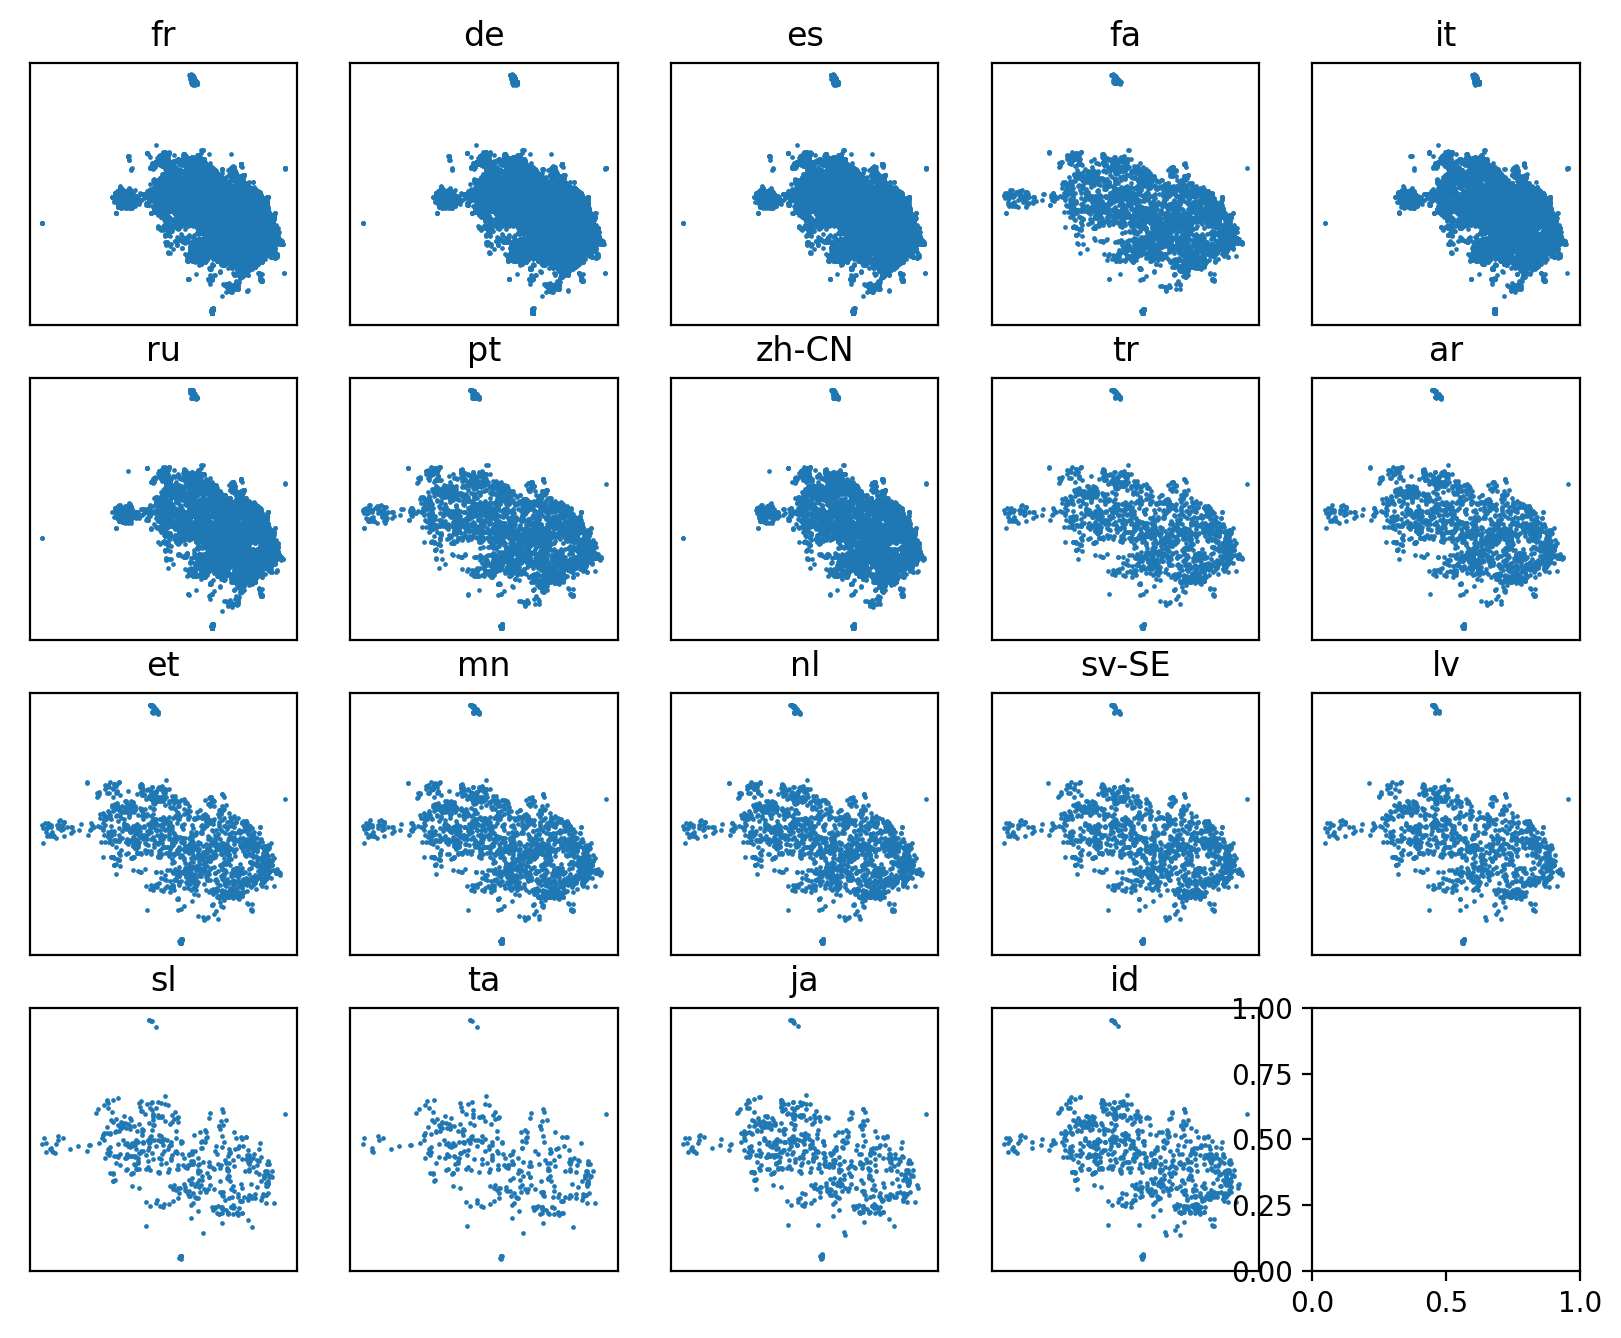

In [ ]:
cnt = 0
fig, axs = plt.subplots(4, 5, dpi=200, figsize=(10, 8))
for idx, lang in enumerate(langs):
    ax = axs[idx // 5, idx % 5]
    ax.scatter(*zip(*dots[cnt:cnt + n_labels[idx]]), label=lang, s=0.5)
    ax.set_title(lang)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('umap.png')

# Extract cross-lingual sentences with similar projected embeddings

In [45]:
tgt_texts_per_lang = []
for lang in langs:
    df = load_df_from_tsv(os.path.join(root, lang, 'dev_st_{}_en.tsv'.format(lang)))
    tgt_texts = df['tgt_text'].tolist()
    tgt_texts_per_lang.append(tgt_texts)

In [46]:
de_start = n_labels[0]
de_end = n_labels[0] + n_labels[1]

zh_start = sum(n_labels[:7])
zh_end = sum(n_labels[:8])

tgt_texts_de = tgt_texts_per_lang[1]
tgt_texts_zh = tgt_texts_per_lang[7]

In [57]:
min_ids = []
min_dists = []
for i in tqdm(range(de_start, de_end)):
    min_id = -1
    min_dist = 1e9
    for j in range(zh_start, zh_end):
        dist = ((dots[i] - dots[j]) ** 2).sum()
        if dist < min_dist:
            min_dist = dist
            min_id = j
    min_ids.append(min_id)
    min_dists.append(min_dist)

  0%|          | 0/13511 [00:00<?, ?it/s]

In [58]:
thres = sorted(min_dists)[int(len(min_dists) * 0.01)]
print(thres)

2.1462813e-05


In [59]:
pairs = []
for i in range(de_start, de_end):
    if min_dists[i - de_start] <= thres:
        pairs.append((tgt_texts_de[i - de_start], tgt_texts_zh[min_ids[i - de_start] - zh_start]))

In [60]:
# projected
print(*pairs, sep='\n')

('All oars are covered with fabric.', 'Kim Dynasty is abolished.')
('The destruction of its habitat is the main threat for the reddish-gray mouse lemur.', 'Most species of this genus are pathogens and can infect humans and other animals.')
('Its main location is Rioz.', 'Maputo International Airport is in Maputo, capital of the Republic of Mozambique.')
('According to this, children go through stages of cultural human development over the course of their socialization.', 'However, on the other side, critical and unfavorable opinions fell on her works by some readers.')
('Technically, the mineral is opaque, but fine chips may appear translucent red.', 'Black medicines are fake medicines and inferior medicines.')
('The anesthetic should be used with caution, however.', 'But the final result is different from the original state.')
('The city wall is heritage listed.', 'The most important building is a noble residential area and a place where the priests hold funeral activities.')
('The co

In [56]:
# original
print(*pairs, sep='\n')

('His mother tongue is French.', 'The mother tongue is Zhongyuan Mandarin.')
('Agriculture is the main source of income.', 'Tourism is the main industry.')
('There are additional galleries and venues on the municipal territory of Windisch.', 'There are a City Museum and Gallery in urban areas.')
('Dushanbe is the capital of Tajikistan.', 'The capital is Dresden.')
('Spanish is a world language too.', 'Russian is also an important language.')
('During World War I, aircraft construction became the most important industry.', 'World War II, like World War I, greatly promoted the development of the aircraft industry.')
('She had two children.', 'They have two daughters.')
('Maputo is the capital of Mozambique.', 'Maputo International Airport is in Maputo, capital of the Republic of Mozambique.')
('In the first round group, each team plays against every other.', 'Each team will compete once with a team in the other group that it has not played against before.')
('He was married and has two c

# Exact Search 

In [6]:
all_features = []
n_labels = []
for i in tqdm(range(len(langs))):
    features = np.load('resources/{}.npy'.format(langs[i]))
    n_labels.append(features.shape[0])
    all_features.append(features)

  0%|          | 0/19 [00:00<?, ?it/s]

In [25]:
d = all_features[0][0].shape[0]
index = faiss.IndexFlatIP(d)
index.add(all_features[0])

In [26]:
D, I = index.search(all_features[1], 5)

In [35]:
exact_matrix = np.zeros((len(langs), len(langs)))
d = all_features[0][0].shape[0]
for i in range(len(langs)):
    index = faiss.IndexFlatIP(d)
    index.add(all_features[i])
    for j in tqdm(range(len(langs)), desc=langs[i]):
        D, I = index.search(all_features[j], 1)
        exact_matrix[i, j] = D.mean()

fr:   0%|          | 0/19 [00:00<?, ?it/s]

de:   0%|          | 0/19 [00:00<?, ?it/s]

es:   0%|          | 0/19 [00:00<?, ?it/s]

fa:   0%|          | 0/19 [00:00<?, ?it/s]

it:   0%|          | 0/19 [00:00<?, ?it/s]

ru:   0%|          | 0/19 [00:00<?, ?it/s]

pt:   0%|          | 0/19 [00:00<?, ?it/s]

zh-CN:   0%|          | 0/19 [00:00<?, ?it/s]

tr:   0%|          | 0/19 [00:00<?, ?it/s]

ar:   0%|          | 0/19 [00:00<?, ?it/s]

et:   0%|          | 0/19 [00:00<?, ?it/s]

mn:   0%|          | 0/19 [00:00<?, ?it/s]

nl:   0%|          | 0/19 [00:00<?, ?it/s]

sv-SE:   0%|          | 0/19 [00:00<?, ?it/s]

lv:   0%|          | 0/19 [00:00<?, ?it/s]

sl:   0%|          | 0/19 [00:00<?, ?it/s]

ta:   0%|          | 0/19 [00:00<?, ?it/s]

ja:   0%|          | 0/19 [00:00<?, ?it/s]

id:   0%|          | 0/19 [00:00<?, ?it/s]

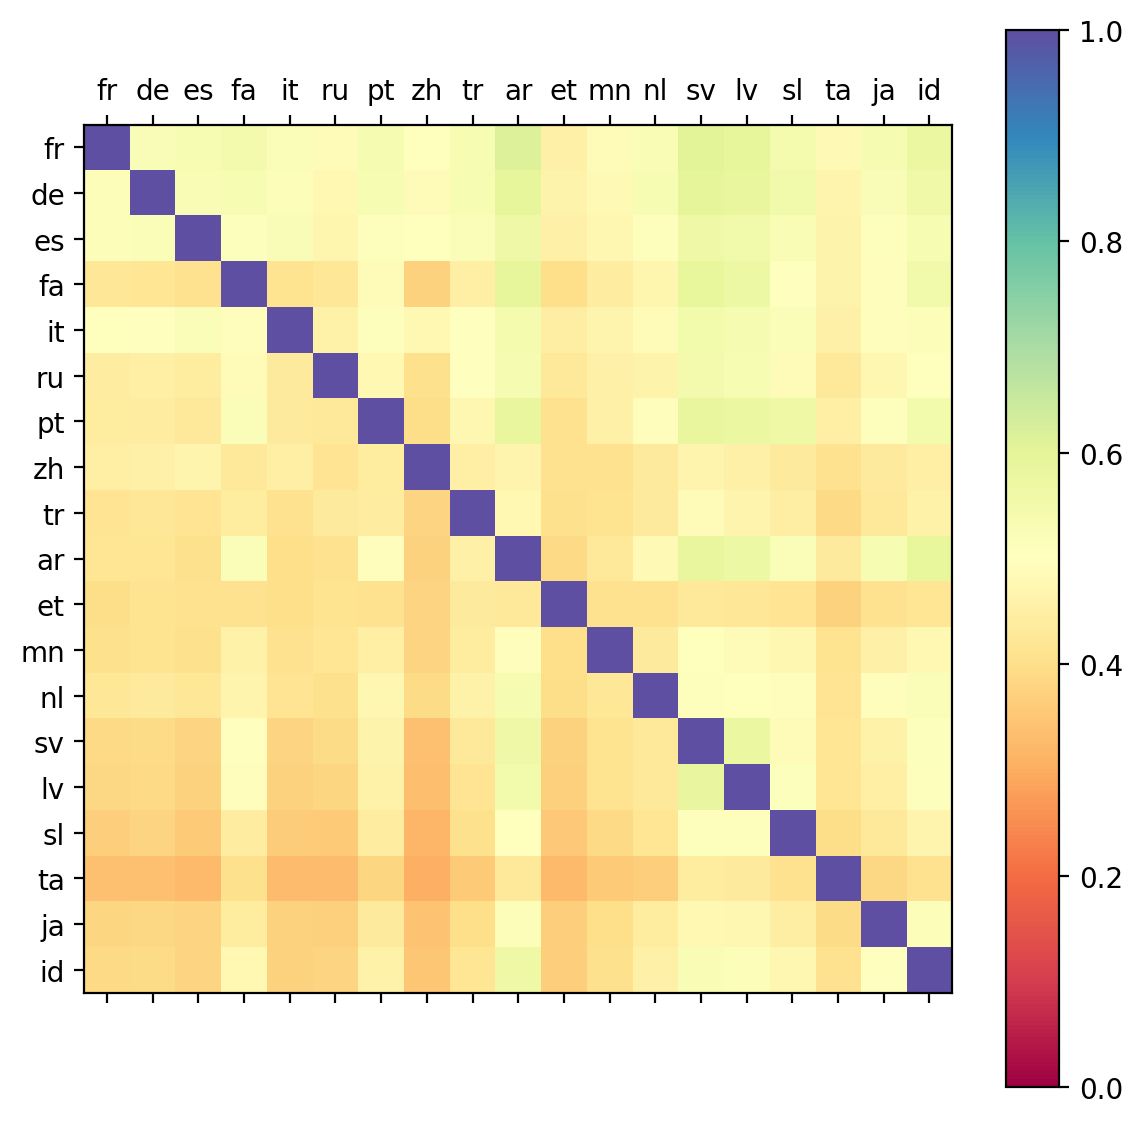

In [47]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(exact_matrix, cmap='Spectral') #, norm=mp.colors.Normalize(0, 7))
cbar = fig.colorbar(cax)
cax.set_clim(0, 1)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('exact_similarity.png')

In [4]:
class MyDataset(Dataset):
    def __init__(self, langs):
        self.langs = langs
        self.data = []
        self.labels = []
        for lang_id, lang in enumerate(langs):
            for batch_idx in tqdm(os.listdir('/mnt/raid0/siqi/analysis/resources-adv/{}'.format(lang)), desc='Lang {}'.format(lang)):
                x = th.load('/mnt/raid0/siqi/analysis/resources-adv/{}/{}'.format(lang, batch_idx), map_location='cpu')
                self.data.extend(x)
                self.labels.extend([lang_id] * len(x))

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def __len__(self):
        return len(self.data)
    
    def collate(self, indices):
        inputs = []
        labels = []

        batch = [self[idx] for idx in indices]
        max_len = max(data.size(0) for data, _ in batch)
        padding_mask = th.zeros(len(batch), max_len).bool()
        for i, (data, label) in enumerate(batch):
            if data.size(0) < max_len:
                padding_mask[i, -(max_len - data.size(0)):] = True
                zeros = th.zeros(max_len - data.size(0), data.size(-1))
                inputs.append(th.cat([data, zeros], dim=0).unsqueeze(1))
            else:
                inputs.append(data.unsqueeze(1))
            labels.append(label)

        inputs = th.cat(inputs, dim=1)
        labels = th.LongTensor(labels)

        return inputs.to(device), padding_mask.to(device), labels.to(device)


In [107]:
dataset = MyDataset(langs)

Lang fr:   0%|          | 0/867 [00:00<?, ?it/s]

Lang de:   0%|          | 0/812 [00:00<?, ?it/s]

Lang es:   0%|          | 0/866 [00:00<?, ?it/s]

Lang fa:   0%|          | 0/186 [00:00<?, ?it/s]

Lang it:   0%|          | 0/590 [00:00<?, ?it/s]

Lang ru:   0%|          | 0/406 [00:00<?, ?it/s]

Lang pt:   0%|          | 0/188 [00:00<?, ?it/s]

Lang zh-CN:   0%|          | 0/323 [00:00<?, ?it/s]

Lang tr:   0%|          | 0/70 [00:00<?, ?it/s]

Lang ar:   0%|          | 0/62 [00:00<?, ?it/s]

Lang et:   0%|          | 0/113 [00:00<?, ?it/s]

Lang mn:   0%|          | 0/106 [00:00<?, ?it/s]

Lang nl:   0%|          | 0/71 [00:00<?, ?it/s]

Lang sv-SE:   0%|          | 0/52 [00:00<?, ?it/s]

Lang lv:   0%|          | 0/57 [00:00<?, ?it/s]

Lang sl:   0%|          | 0/13 [00:00<?, ?it/s]

Lang ta:   0%|          | 0/36 [00:00<?, ?it/s]

Lang ja:   0%|          | 0/31 [00:00<?, ?it/s]

Lang id:   0%|          | 0/32 [00:00<?, ?it/s]

In [108]:
th.save(dataset, '/mnt/raid0/siqi/analysis/adv_semantic_dataset.pt')

In [7]:
dataset = th.load('/mnt/raid0/siqi/analysis/ref_audio_dataset.pt')
all_features = [[] for _ in range(len(langs))]
for x, lang_id in dataset:
    x = x.numpy()
    x /= np.linalg.norm(x)
    all_features[lang_id].append(x)
all_features = [np.stack(ft) for ft in all_features]

In [122]:
exact_audio_matrix = np.zeros((len(langs), len(langs)))
d = all_features[0][0].shape[0]
for i in range(len(langs)):
    index = faiss.IndexFlatIP(d)
    index.add(np.stack(all_features[i]))
    for j in tqdm(range(len(langs)), desc=langs[i]):
        D, I = index.search(np.stack(all_features[j]), 1)
        exact_audio_matrix[i, j] = D.mean()

fr:   0%|          | 0/19 [00:00<?, ?it/s]

de:   0%|          | 0/19 [00:00<?, ?it/s]

es:   0%|          | 0/19 [00:00<?, ?it/s]

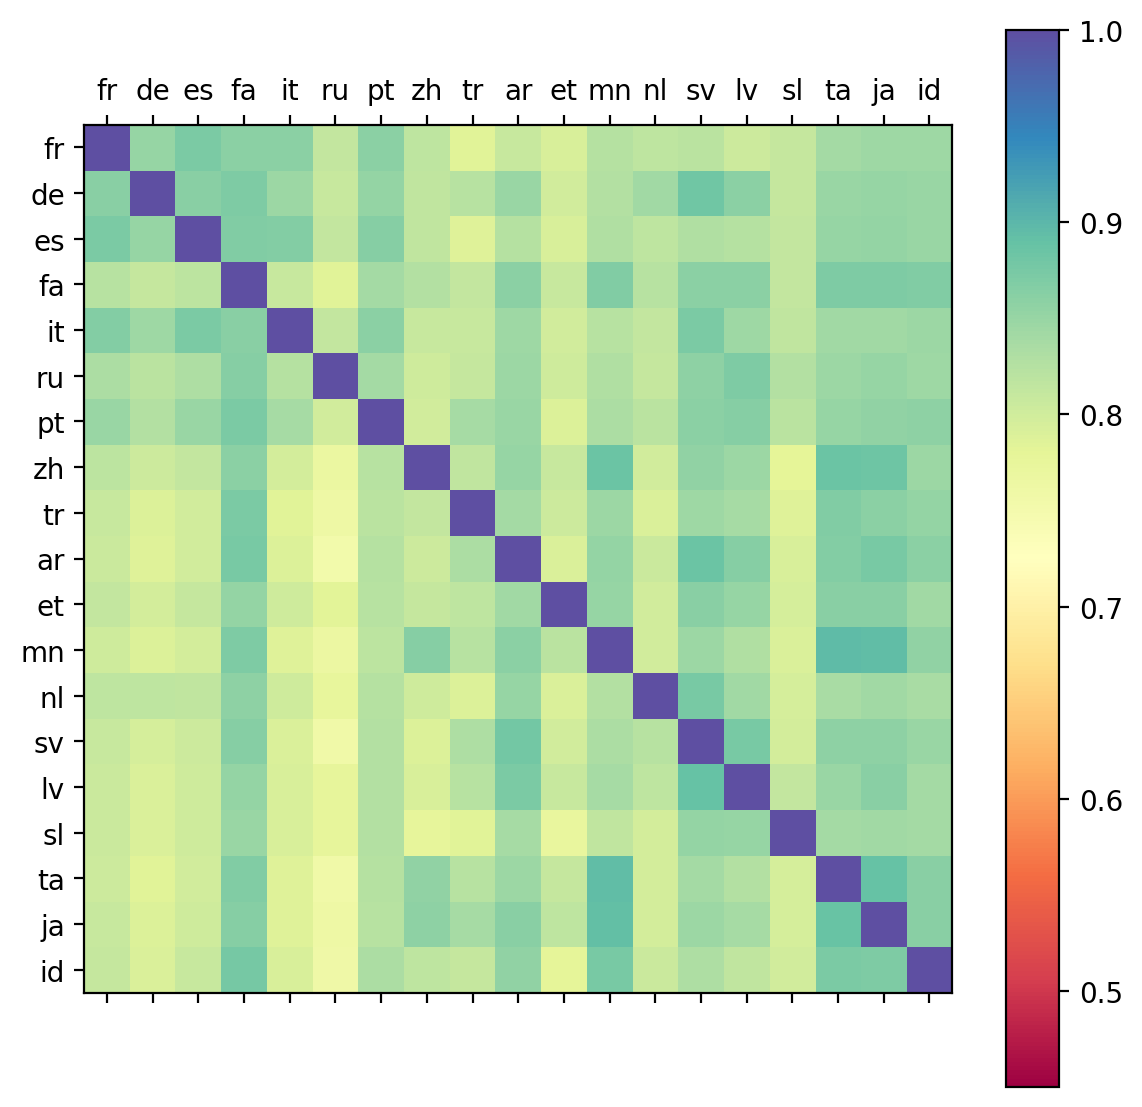

In [ ]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(exact_audio_matrix, cmap='Spectral') #, norm=mp.colors.Normalize(0, 7))
cbar = fig.colorbar(cax)
cax.set_clim(0.75, 1)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('adv_exact_audio_similarity.png')

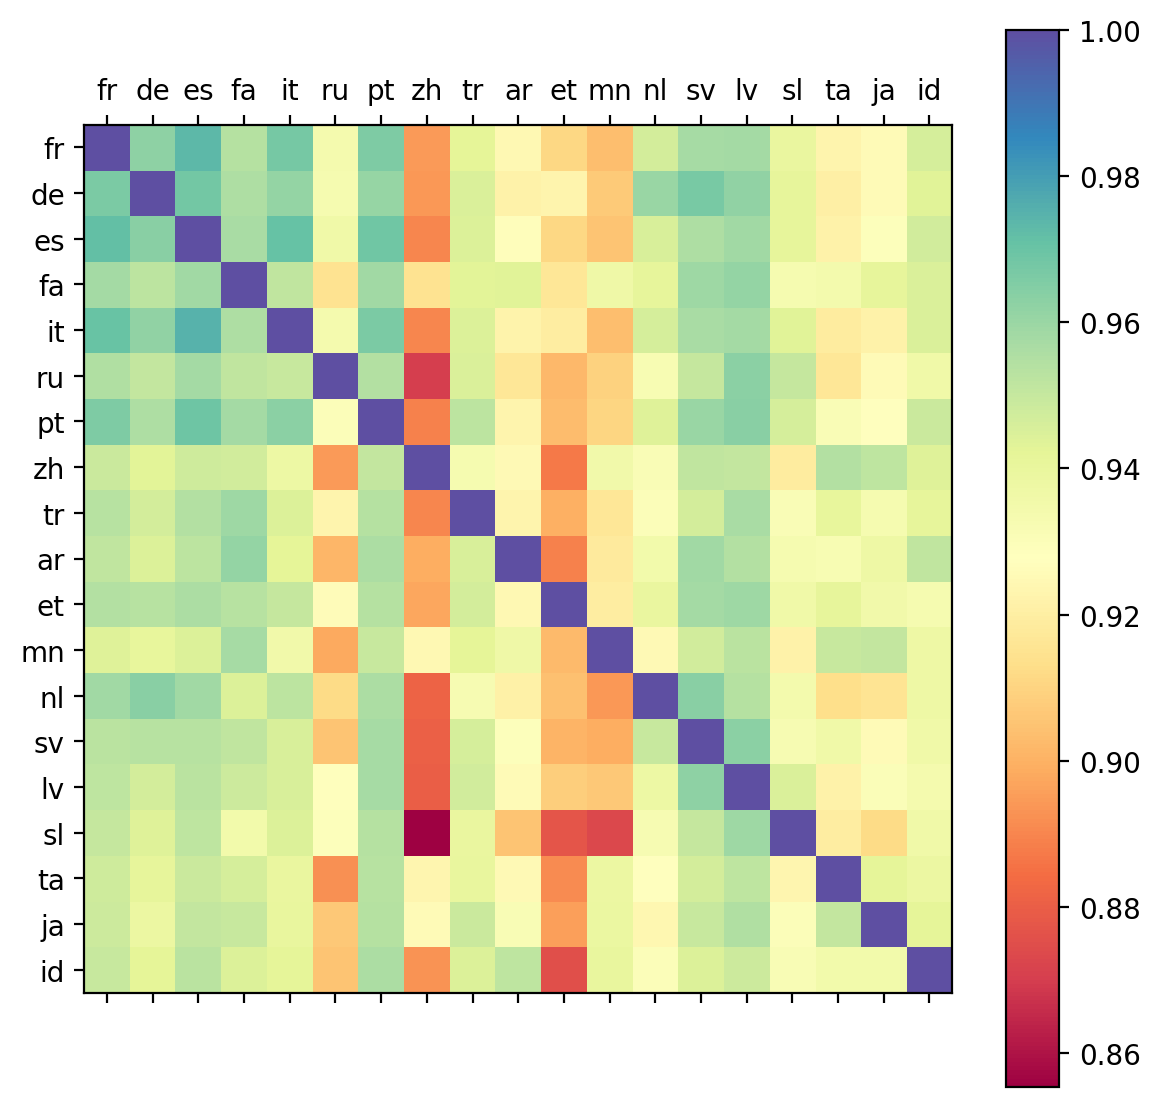

In [76]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(exact_audio_matrix, cmap='Spectral') #, norm=mp.colors.Normalize(0, 7))
cbar = fig.colorbar(cax)
# cax.set_clim(0, 1)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('adv_exact_audio_similarity.png')

In [112]:
std_matrix = exact_audio_matrix

In [116]:
adv_matrix = exact_audio_matrix

In [117]:
delta_matrix = adv_matrix - std_matrix

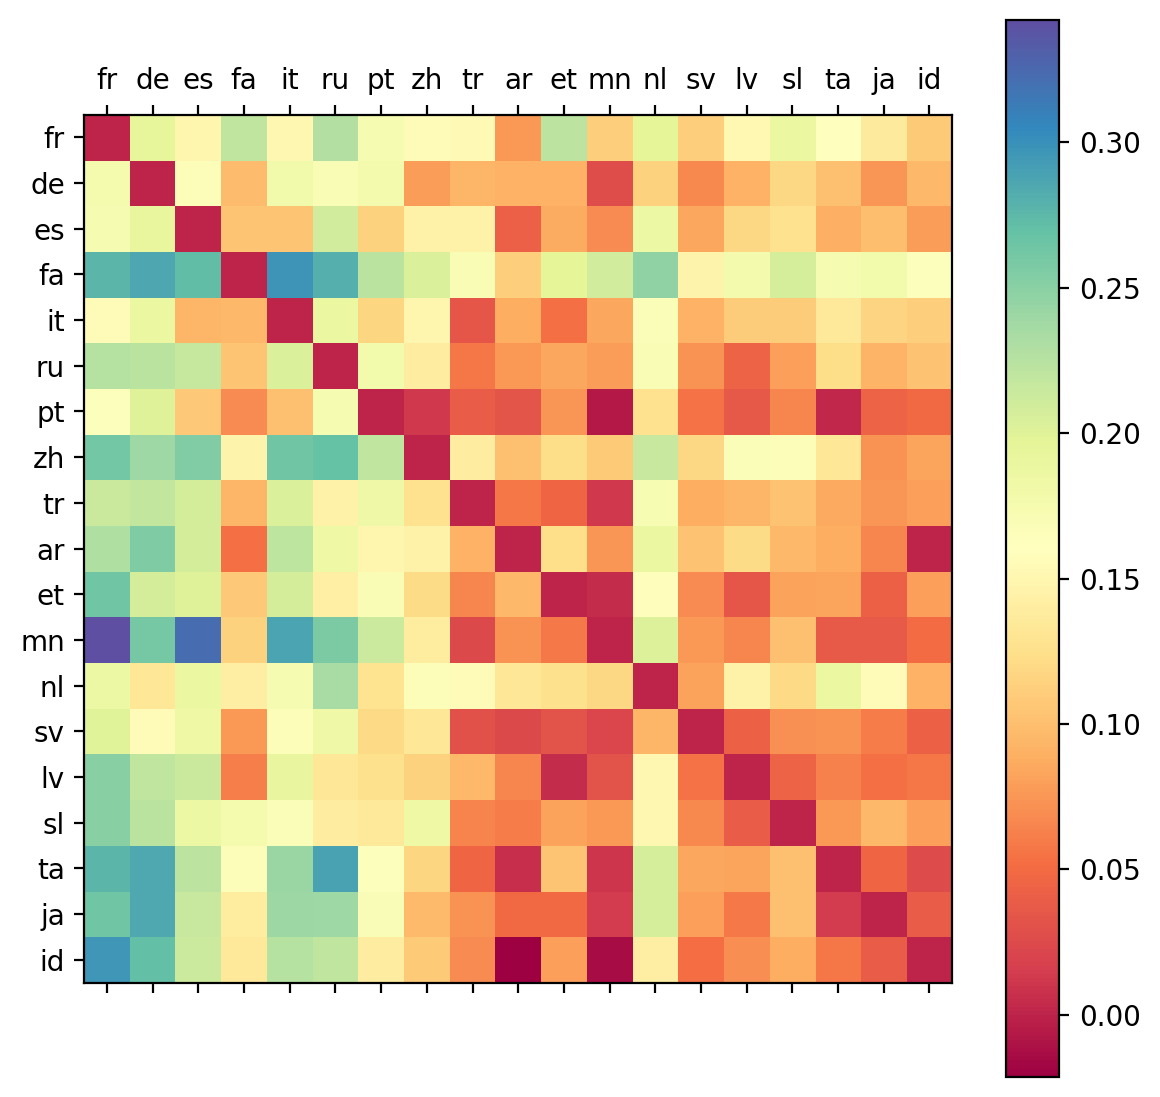

In [118]:
fig = plt.figure(dpi=200, figsize=(7, 7))
ax = fig.add_subplot(111)
cax = ax.matshow(delta_matrix, cmap='Spectral') #, norm=mp.colors.Normalize(0, 7))
cbar = fig.colorbar(cax)
# cax.set_clim(0, 1)
ax.set_xticks(range(len(langs)))
ax.set_yticks(range(len(langs)))
ax.set_xticklabels([lang[:2] for lang in langs])
ax.set_yticklabels([lang[:2] for lang in langs])
plt.savefig('delta_exact_audio_similarity.png')

In [ ]:
dataset = th.load('/mnt/raid0/siqi/analysis/adv_dataset.pt')

In [94]:
all_features = [[] for _ in range(len(langs))]
for seq_feature, lang_id in tqdm(dataset):
    x = seq_feature.mean(dim=0).cpu().numpy()
    x /= np.linalg.norm(x)
    all_features[lang_id].append(x)

  0%|          | 0/64060 [00:00<?, ?it/s]

In [95]:
adv_exact_matrix = np.zeros((len(langs), len(langs)))
d = all_features[0][0].shape[0]
for i in range(len(langs)):
    index = faiss.IndexFlatIP(d)
    index.add(np.stack(all_features[i]))
    for j in tqdm(range(len(langs)), desc=langs[i]):
        D, I = index.search(np.stack(all_features[j]), 1)
        adv_exact_matrix[i, j] = D.mean()

fr:   0%|          | 0/19 [00:00<?, ?it/s]

ValueError: need at least one array to stack